In [43]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import os
import pathlib
import sys
import random
import shutil
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from skimage import exposure


In [44]:
IMAGE_SIZE = 256
pathtxt = pathlib.Path('pathtxt/')
data = pathlib.Path('datasetproject/')
train_data = pathlib.Path('datasetproject/train')
test_data = pathlib.Path('datasetproject/test')
split_ratio = 0.20

Download the dataset from:

https://www.aicrowd.com/challenges/snakeclef2021-snake-species-identification-challenge/dataset_files

Files to be download:
1 - SnakeCLEF-2021 - TrainingData
2 - SnakeCLEF2021 - TrainVal Metadata


## List and id of species for this projects

001 |Vipera berus
002 |Vipera ursinii
003 |Vipera seoanei
004 |Vipera ammodytes
005 |Vipera seoanei
006 |Vipera xanthina
007 |Vipera nikolskii


To do List
1 - Unzip the Train Data
2 - Found the path to each species on TrainVal MetadatA
3 - Create one folder for each image on our list(folder nome the ID)
4 - Randonaly split the dataset
Dataset Clean
1 - Remove bad images (visual inspection)
2 - Normalize all images of dataset (same size and dived by 256)


In [45]:

if not os.path.exists(data):
    os.makedirs(data)
if not os.path.exists(train_data):
    os.makedirs(train_data)
if not os.path.exists(test_data):
    os.makedirs(test_data)

def creat_fold():

    for filename in pathtxt.glob('*.txt'):
        foldername = filename.name.split('.')[0]
        pathSpecies =train_data.joinpath(foldername)
        pathlib.Path(pathSpecies).mkdir()

        with open(filename) as datafile:
            for i, line in enumerate(datafile.readlines()):
                line = line.rstrip('\n')
                name = line.split('/')[-1]
                shutil.copyfile(line, train_data.joinpath(foldername).joinpath(name))

# creat_fold()


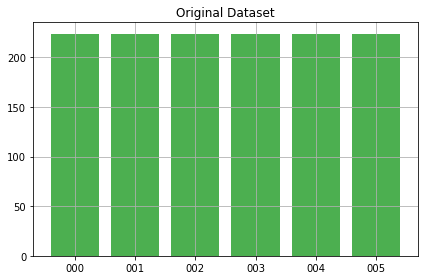

In [46]:
def count_dataset(pathbase):
    qtd = []
    lab = []
    for dr in pathbase.iterdir():
        files = os.listdir(dr)
        qtd.append(len(files))
        lab.append(dr.name)
    return qtd, lab

qtd_orig, lab_orig = count_dataset(train_data)

plt.bar(lab_orig, qtd_orig, color = "#4CAF50")
plt.title("Original Dataset")
plt.tight_layout()
plt.yscale('linear')
plt.grid()

plt.show()

In [47]:

def split_data():

    for dr in train_data.glob('*/'):
        pathSpecies =test_data.joinpath(dr.name)
        pathlib.Path(pathSpecies).mkdir()
        files = os.listdir(dr)

        random.shuffle(files)
        qtd = round(len(files) * split_ratio)

        for i in range(qtd):
            src = train_data.joinpath(dr.name).joinpath(files[i])
            dst = test_data.joinpath(dr.name).joinpath(files[i])
            os.rename(src, dst)

    return 

# split_data()


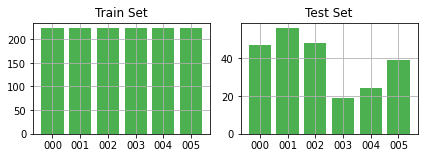

In [48]:
qtd_train, lab_train = count_dataset(train_data)
qtd_test, lab_test = count_dataset(test_data)

plt.subplot(2, 2, 1)
plt.bar(lab_train, qtd_train , color = "#4CAF50")
plt.title("Train Set")
plt.tight_layout()
plt.yscale('linear')
plt.grid()

plt.subplot(2, 2, 2)
plt.bar(lab_test, qtd_test, color = "#4CAF50")
plt.title("Test Set")
plt.tight_layout()
plt.yscale('linear')
plt.grid()

plt.show()

Data Augmentation 

We notice that our dataset is umbaleced so, we will try to use data augmentation to balaced our train set. 

We only use the data augmentation in the train set, and we will keep the test set. 

In [49]:
def random_rotate (image):
    angle = random.randint(0, 360)
    rows, cols, c = image.shape
    M = cv.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    image = cv.warpAffine(image, M, (cols, rows))

    return image
def flip(image):
    
    hflip = random.choice([True, False])
    vflip = random.choice([True, False])

    if hflip and vflip:
        c = -1
    else:
        c = 0 if vflip else 1

    return cv.flip(image, flipCode=c)

def saturation(image):
    n = random.randint(1, 4)
    return np.array (tf.image.adjust_saturation(image, n))

def crop(image): 
    return np.array (tf.image.central_crop(image, central_fraction=0.5))

def dilation_image(image):
    shift = random.randint(2, 7)
    kernel = np.ones((shift, shift), np.uint8)
    image = cv.dilate(image, kernel, iterations=1)
    return image

def erosion_image(image):
    shift = random.randint(2, 7)
    kernel = np.ones((shift, shift), np.uint8)
    image = cv.erode(image, kernel, iterations=1)
    return image

def brightness(image):
    return np.array (tf.image.adjust_brightness(image, 0.3))

# Histogram is much easier with sckit-image
# Opencv we can only do histogram of gray image
def HE(image):
    image = exposure.equalize_hist(image)
    return cv.convertScaleAbs(image*255)

def AHE(image):
    image = exposure.equalize_adapthist(img, clip_limit=0.03)
    return cv.convertScaleAbs(image*255)

# Blur image for edge detection
def medianblur(image):
    kernel_size = random.randrange(3,9,2)
    return cv.medianBlur(image, kernel_size)

def gaussianblur(image):
    kernel_size = random.randrange(3,9,2)
    return cv.GaussianBlur(image, (kernel_size, kernel_size), 0)


(-0.5, 499.5, 374.5, -0.5)

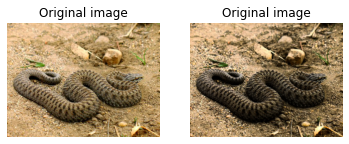

In [50]:
def HECOLOR (image):
    # channels = cv.split(image)
    # eq_channels = []
    # for ch, color in zip(channels, ['B', 'G', 'R']):
    #     eq_channels.append(cv.equalizeHist(ch))

    # eq_image = cv.merge(eq_channels)
    # eq_image = cv.cvtColor(eq_image, cv.COLOR_BGR2RGB)

    H, S, V = cv.split(cv.cvtColor(image, cv.COLOR_BGR2HSV))
    eq_V = cv.equalizeHist(V)
    eq_image = cv.cvtColor(cv.merge([H, S, eq_V]), cv.COLOR_HSV2RGB)

    return eq_image

img = cv.imread('testimage.jpg')

image_he = HECOLOR(img)

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# HE = cv.cvtColor(HE, cv.COLOR_BGR2RGB)


plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title('Original image')
plt.imshow(image_he)
plt.axis("off")

(-0.5, 499.5, 374.5, -0.5)

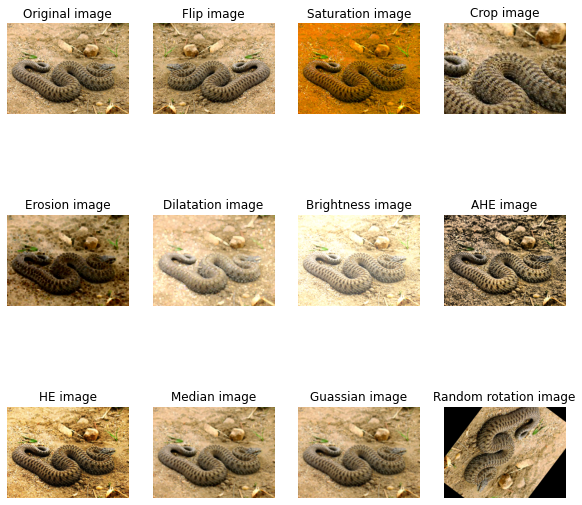

In [51]:
   
img = cv.imread('testimage.jpg')
# Convert image from BGR to RGB
# Matliplot use RGB
# Opencv use BGR
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10, 10))

plt.subplot(3,4,1)
plt.title('Original image')
plt.imshow(img)
plt.axis("off")

plt.subplot(3,4,2)
plt.title('Flip image')
plt.imshow(flip(img))
plt.axis("off")

plt.subplot(3,4,3)
plt.title('Saturation image')
plt.imshow(saturation(img))
plt.axis("off")

plt.subplot(3,4,4)
plt.title('Crop image')
plt.imshow(crop(img))
plt.axis("off")

plt.subplot(3,4,5)
plt.title('Erosion image')
plt.imshow(erosion_image(img))
plt.axis("off")

plt.subplot(3,4,6)
plt.title('Dilatation image')
plt.imshow(dilation_image(img))
plt.axis("off")

plt.subplot(3,4,7)
plt.title('Brightness image')
plt.imshow(brightness(img))
plt.axis("off")

plt.subplot(3,4,8)
plt.title('AHE image')
plt.imshow(AHE(img))
plt.axis("off")

plt.subplot(3,4,9)
plt.title('HE image')
plt.imshow(HE(img))
plt.axis("off")

plt.subplot(3,4,10)
plt.title('Median image')
plt.imshow(medianblur(img))
plt.axis("off")

plt.subplot(3,4,11)
plt.title('Guassian image')
plt.imshow(gaussianblur(img))
plt.axis("off")

plt.subplot(3,4,12)
plt.title('Random rotation image')
plt.imshow(random_rotate(img))
plt.axis("off")

In [52]:

data_augmentation_function = [random_rotate, flip, saturation, crop, dilation_image, erosion_image, brightness,  HE, AHE,  gaussianblur]

def data_augmentation(data_directory):
    
    countImg = 0

    directories = [d for d in os.listdir(data_directory)
                   if os.path.isdir(os.path.join(data_directory, d))]
  
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f)
                      for f in os.listdir(label_directory)]
        
        qtd_files = len(file_names)
        
        while qtd_files < 224:  # 
            pathPhoto = random.choice(file_names)
            img = cv.imread(pathPhoto)

            function = random.choice(data_augmentation_function)
            
            imgArtificial = function(img)

            cv.imwrite(os.path.dirname(pathPhoto) + "/"+ str(countImg).zfill(3)+ "_artificial_"+ function.__name__ + ".jpg", imgArtificial)
            countImg +=1
            qtd_files += 1

            
data_augmentation(train_data)


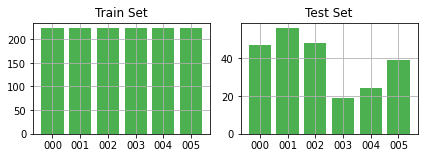

In [53]:
qtd_train, lab_train = count_dataset(train_data)
qtd_test, lab_test = count_dataset(test_data)

plt.subplot(2, 2, 1)
plt.bar(lab_train, qtd_train , color = "#4CAF50")
plt.title("Train Set")
plt.tight_layout()
plt.yscale('linear')
plt.grid()

plt.subplot(2, 2, 2)
plt.bar(lab_test, qtd_test, color = "#4CAF50")
plt.title("Test Set")
plt.tight_layout()
plt.yscale('linear')
plt.grid()

plt.show()